In [1]:
from Game import *

Version:  0.2.20


In [2]:
def initial_state():
    b=Board(3,3)
    b.pieces=['.','X','O']
    return b

In [3]:
def valid_moves(board,player):

    empty=[]
    for i in range(9):
        if board[i]==0:
            empty.append(i)

    return empty

In [4]:
def check_three_in_a_row(row):

    if row[0]==1 and row[1]==1 and row[2]==1:
        return 1
    elif row[0]==2 and row[1]==2 and row[2]==2:
        return 2
    else:
        return 0

In [5]:
def win_status(board,player):
    # in ttt, after a move, that player can either win or stalemate
    # they can't lose after their own move
    
    if check_three_in_a_row( [board[0],board[1],board[2] ])==player:
        return 'win'

    if check_three_in_a_row( [board[2],board[5],board[8] ])==player:
        return 'win'

    if check_three_in_a_row( [board[3],board[4],board[5] ])==player:
        return 'win'

    if check_three_in_a_row( [board[6],board[7],board[8] ])==player:
        return 'win'

    if check_three_in_a_row( [board[0],board[3],board[6] ])==player:
        return 'win'

    if check_three_in_a_row( [board[1],board[4],board[7] ])==player:
        return 'win'

    if check_three_in_a_row( [board[0],board[4],board[8] ])==player:
        return 'win'

    if check_three_in_a_row( [board[6],board[4],board[2] ])==player:
        return 'win'


    # stalemate
    tie=True
    for i in range(9):
        if board[i]==0:
            tie=False

    if tie:
        return 'stalemate'



    return None


In [6]:
def update_state(board,player,move):
    board[move]=player
    return board


In [7]:
def show_state(board):

    print(board)
    
    print()
    print("Choices:")
    print("""
     0 | 1 | 2
    ---+---+---
     3 | 4 | 5
    ---+---+---
     6 | 7 | 8
    """)


In [32]:
def random_move(state,player,memory=None):

    moves=valid_moves(state,player)
    return random.choice(moves)

def first_move(state,player,memory=None):

    moves=valid_moves(state,player)
    return moves[0]

def human_move(state,player,memory=None):
    print("Player ", player, end=' ')
    valid_move=False
    while not valid_move:
        move=eval(input('What is your move? '))

        if move in valid_moves(state,player):
            valid_move=True
        else:
            print("Illegal move.")

    return move
 

In [33]:
human_agent=Agent(human_move)
random_agent=Agent(random_move)
first_agent=Agent(first_move)


In [34]:
# g=Game(number_of_games=1)
# g.run(human_agent,random_agent)
# g.report()   # state the percentage of wins, ties, etc...

In [35]:
from collections import UserList
class ActionList(UserList):
    
    def sample(self):
        return random.choice(self)

from copy import deepcopy
class GameEnv(object):
    
    def __init__(self):
        self.functions=Struct()
        self.functions.initial_state=initial_state
        self.functions.valid_moves=valid_moves
        self.functions.update_state=update_state
        self.functions.show_state=show_state
        self.functions.win_status=win_status

        self.reset()
    
    def reset(self):
        self.player=1
        self.state=self.functions.initial_state(),self.player
    
        observation=self.state
        return observation

    def render(self,mode='human'):
        if mode=='human':
            board,player=self.state
        
            print(f"Player {player}\nBoard:\n{board}")
        else:
            raise NotImplementedError
    
    @property
    def action_space(self):
        board,player=self.state
        valid_moves=self.functions.valid_moves(board,player)
        return ActionList(valid_moves)
    
    def step(self,action):
        board,player=self.state
        valid_moves=self.functions.valid_moves(board,player)

        if action not in valid_moves:
            observation,reward,done,info=self.state,-1000,True,None
            return observation,reward,done,info
        
        
        move=action
        board=deepcopy(board)  # update state might change the board
        new_board=self.functions.update_state(board,player,move)
        
        status=self.functions.win_status(new_board,player)
        if status=='win':
            observation,reward,done,info=self.state,100,True,None
            return observation,reward,done,info
        elif status=='lose':
            observation,reward,done,info=self.state,-100,True,None
            return observation,reward,done,info
        elif status=='stalemate':
            observation,reward,done,info=self.state,0,True,None
            return observation,reward,done,info
        elif status is None:
            if self.player==1:
                self.player=2
            else:
                self.player=1
                
            self.state=new_board,self.player

            observation,reward,done,info=self.state,0,False,None
            return observation,reward,done,info
        else:
            raise ValueError
    
    def close(self):
        pass
    
    

## Can I do Q-learning?

In [12]:
def Q_move(board,player,memory):  # just the move
    Q=memory.Q
    alpha=memory.alpha
    gamma=memory.gamma
    epsilon=memory.epsilon
    
    if not board in Q:
        Q[board]=Table()
        for action in valid_moves(board,player):
            Q[board][action]=0.0

    if random.random()<epsilon:  # random move
        action=random_choice(Q[board])
    else:
        action=top_choice(Q[board])

    return action

        
def Q_update(old_observation,action,new_observation,reward,done,memory):
    Q=memory.Q
    alpha=memory.alpha
    gamma=memory.gamma
    epsilon=memory.epsilon
    
    if done:
        board,player = old_observation
        Q[board][action]+=alpha*(reward - Q[board][action] )
    else:
        board,player = old_observation
        new_board,new_player = new_observation
        assert player==player
    
        Q[board][action]+=alpha*(reward + 
                                 gamma*max([Q[new_board][a] for a in Q[new_board]]) - 
                                 Q[board][action] )  

In [13]:
from numpy import exp

In [14]:
Qmemory=Struct()
Qmemory.Q=Table()
Qmemory.alpha=0.3
Qmemory.gamma=0.9
Qmemory.epsilon=.1
Qmemory.epsilon_decay=0.01      

Q_agent=Agent(Q_move)
Q_agent.update=Q_update

In [15]:
train_episodes = 2000    
test_episodes = 100
max_steps=500

In [31]:
agents={1:first_agent,
        2:Q_agent,
       }

memories={1:None,
         2: Qmemory}

observations={1:[],
             2:[],}

actions={1:[],
         2:[],}

rewards={1:[],
         2:[],}



env = GameEnv()

#Training the agent

#Creating lists to keep track of reward and epsilon values
training_rewards = []
epsilons = []

for episode in range(train_episodes):
    #Reseting the environment each time as per requirement
    observation = env.reset()

    #Starting the tracker for the rewards
    total_training_rewards = 0
    
    for step in range(max_steps):
        #env.render()
        
        board,player=observation
        observations[player].append(observation)
        other_player=3-player
        
        action=agents[player].move(board,player,memories[player])
        actions[player].append(action)
        
        #print(f"action: {action}")
        new_observation, reward, done, info = env.step(action)
        
        
        if memories[player]:
            agents[player].update(observation,action,reward,done,memories[player])
        
        if done and memories[other_player]:
            agents[other_player].update(None,None,reward,done,memories[other_player])  # not my turn, but the learning needs to be done
        
        
        #Increasing our total reward and updating the state
        if player==2:
            total_training_rewards += reward      
            
        observation = new_observation     
        
        #Ending the episode
        if done == True:
            #print ("Total reward for episode {}: {}".format(episode, total_training_rewards))
            break
    
    #Cutting down on exploration by reducing the epsilon 
    memory=memories[2]
    epsilon=memory.epsilon
    #memory.epsilon = min_epsilon + (max_epsilon - min_epsilon)*exp(-decay*episode)
    
    #Adding the total reward and reduced epsilon values
    training_rewards.append(total_training_rewards)
    epsilons.append(epsilon)
    

print ("Training score over time: " + str(sum(training_rewards)/train_episodes))

wins=0
losses=0
ties=0

for episode in range(test_episodes):
    observation = env.reset()
    for step in range(max_steps):
        #env.render()
        
        board,player=observation
        other_player=3-player
        
        action=agents[player].move(board,player,memories[player])
        #print(f"action: {action}")
        new_observation, reward, done, info = env.step(action)
        observation = new_observation   
        
        
        if done:
            if player==2:
                reward=-reward
            
            if reward==100:
                wins+=1
            elif reward==-100:
                losses+=1
            elif reward==0:
                ties+=1
            else:
                raise ValueError
                
               
            break
            
print("wins:",wins/test_episodes*100)
print("losses:",losses/test_episodes*100)
print("ties:",ties/test_episodes*100)
                

            
        

Training score over time: 16.35
wins: 79.0
losses: 14.000000000000002
ties: 7.000000000000001


In [26]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/bblais/opt/anaconda3/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['info', 'step']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


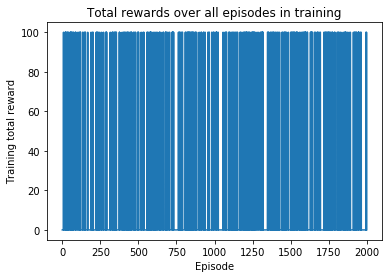

In [27]:
#Visualizing results and total reward over all episodes
x = range(train_episodes)
plot(x, training_rewards)
xlabel('Episode')
ylabel('Training total reward')
title('Total rewards over all episodes in training') 
show()

In [19]:
Q

NameError: name 'Q' is not defined